In [2]:
from css_utility_expansion_dev import *

In [9]:
path_1="../database_exp/prom/predict/regression_log_adj01/pred_results.csv"
pred_result_csv=pd.read_csv(path_1)
pred_result_csv

,True_RPKM,Predicted_RPKM
0,0.163818,0.387680
1,3.857947,0.328373
2,0.046884,0.652660
3,2.448502,2.861803
4,2.509355,2.291774
...,...,...
190342,0.000000,0.222446
190343,2.174411,2.637344
190344,2.960468,3.123514
190345,1.141672,1.650047


In [18]:
path_pred="../database_exp/prom/predict/regression_log_adj01/pred_values.npy"
path_true="../database_exp/prom/predict/regression_log_adj01/true_values.npy"

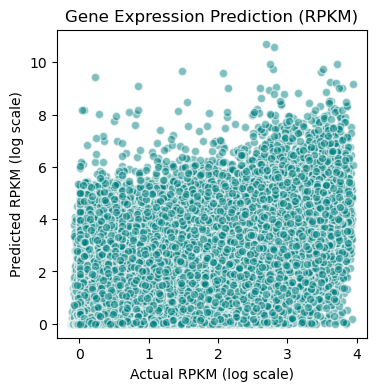

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Load predictions and actual values
true_rpkm = np.load(path_pred)
pred_rpkm = np.load(path_true)

# Scatter plot
plt.figure(figsize=(4, 4))
plt.scatter(true_rpkm, pred_rpkm, edgecolors='white', color="teal", alpha=0.5)
plt.xlabel("Actual RPKM (log scale)")
plt.ylabel("Predicted RPKM (log scale)")
plt.title("Gene Expression Prediction (RPKM)")
plt.grid(False)

# Save and Show
plt.savefig("scatter_plot.png", dpi=300)
plt.show()


Mean Residual: 0.0143
Standard Deviation: 0.9988
Min Residual: -3.8368
Max Residual: 9.1885


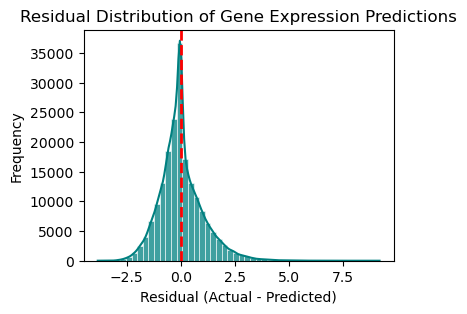

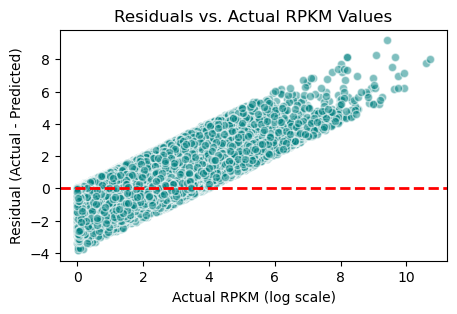

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load actual and predicted RPKM values
actual_rpkm = np.load(path_true)
predicted_rpkm = np.load(path_pred)

# Compute residuals
residuals = actual_rpkm - predicted_rpkm

# Print basic statistics
print(f"Mean Residual: {np.mean(residuals):.4f}")
print(f"Standard Deviation: {np.std(residuals):.4f}")
print(f"Min Residual: {np.min(residuals):.4f}")
print(f"Max Residual: {np.max(residuals):.4f}")

# Plot Residual Histogram
plt.figure(figsize=(4, 3))
sns.histplot(residuals, bins=50, kde=True, color="teal", edgecolor="white", alpha=0.75)
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)  # Reference line at zero
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution of Gene Expression Predictions")
plt.grid(False)
plt.show()

# Plot Residuals vs. Actual Values
plt.figure(figsize=(5, 3))
plt.scatter(actual_rpkm, residuals, edgecolors='white', color="teal", alpha=0.5)
plt.axhline(0, color='red', linestyle='dashed', linewidth=2)  # Reference line at zero
plt.xlabel("Actual RPKM (log scale)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs. Actual RPKM Values")
plt.grid(False)
plt.show()


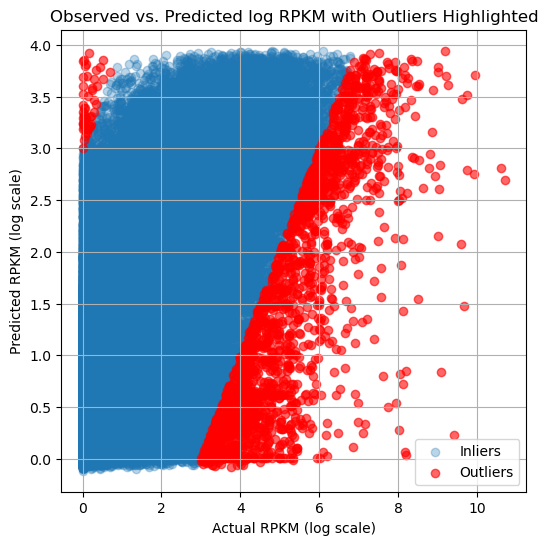

In [49]:
pred_values = np.load(path_pred)
true_values = np.load(path_true)

# Compute residuals
residuals = true_values - pred_values

# Define threshold for outliers (e.g., values beyond 3 standard deviations)
threshold = 3 * np.std(residuals)

# Identify outliers
outliers = np.abs(residuals) > threshold

# Plot scatter plot highlighting outliers
plt.figure(figsize=(6, 6))
plt.scatter(true_values[~outliers], pred_values[~outliers], alpha=0.3, label="Inliers")
plt.scatter(true_values[outliers], pred_values[outliers], color='red', alpha=0.6, label="Outliers")
plt.xlabel("Actual RPKM (log scale)")
plt.ylabel("Predicted RPKM (log scale)")
plt.title("Observed vs. Predicted log RPKM with Outliers Highlighted")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [4]:
path="../database_exp/RNA/hg19/gene_expression/sorted_output/E003_processed.tsv"

In [25]:
import pandas as pd

col_name = ["gene_id", "chromosome", "strand", "TxStart", "TxEnd", "RPKM"]
unit = 200

# Read the file
df = pd.read_csv(path, names=col_name, sep="\t")

# Filter out the unwanted row where 'gene_id' is "name" and explicitly copy the result
df_filtered = df[df['gene_id'] != 'name'].copy()

# Remove rows where 'chromosome' has the value "chrM"
df_filtered = df_filtered[df_filtered['chromosome'] != 'chrM'].copy()

# Convert 'TxStart' and 'TxEnd' from strings to integers
df_filtered['TxStart'] = pd.to_numeric(df_filtered['TxStart'], errors='coerce')
df_filtered['TxEnd'] = pd.to_numeric(df_filtered['TxEnd'], errors='coerce')

# Divide by 'unit', round, and keep them as integers
df_filtered['TxStart'] = (df_filtered['TxStart'] / unit).round().astype(int)
df_filtered['TxEnd'] = (df_filtered['TxEnd'] / unit).round().astype(int)

# Display the result
print(df_filtered)


               gene_id chromosome strand  TxStart   TxEnd   RPKM
0      ENSG00000237613       chr1      -      173     180  0.188
1      ENSG00000186092       chr1      +      345     350    0.0
2      ENSG00000235249       chr1      +     1838    1843  0.011
3      ENSG00000185097       chr1      -     3105    3110    0.0
4      ENSG00000187634       chr1      +     4306    4400  0.034
...                ...        ...    ...      ...     ...    ...
19640  ENSG00000187191       chrY      -   134546  134798    0.0
19641  ENSG00000205916       chrY      +   134900  135266    0.0
19642  ENSG00000185894       chrY      -   135885  135991    0.0
19643  ENSG00000172288       chrY      +   138842  138855    0.0
19644  ENSG00000172283       chrY      +   140608  140671    0.0

[19645 rows x 6 columns]


In [27]:
len(df_filtered["chromosome"].unique())

24

In [34]:
df_filtered["chromosome"].unique()

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chrX', 'chrY'], dtype=object)

In [15]:
cell_pickle_path="../chromatin_state/database/cell_pickle/df_cell001.pkl"
with open(cell_pickle_path,"rb") as ff:
    cell_pickle=pickle.load(ff)

In [16]:
cell_pickle

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10600,9,800,8,I,IIIIIIII
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
...,...,...,...,...,...,...,...,...
510145,chrY,59003800,59005800,15,2000,20,O,OOOOOOOOOOOOOOOOOOOO
510146,chrY,59005800,59006000,9,200,2,I,II
510147,chrY,59006000,59011800,15,5800,58,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
510148,chrY,59011800,59026000,9,14200,142,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [18]:
css_unit_path="../chromatin_state/database/roadmap/css_unit_pickled/E001_unitcss_woChrM.pkl"
with open(css_unit_path,"rb") as gg:
    css_unit=pickle.load(gg)

In [51]:
def create_css_with_rpkm_df(file_path, css_unit_path, unit=200):
    """
    Processes chromatin state data and extracts chromatin state sequences per chromosome.
    1. Read the css_unit_path (the whole css_unit from genome)
    2. Read the EXXX_processed.tsv file which contains gene loci with RPKM value
    3. Extract the gene loci in css_unit with RPKM value
    4. Remove all low-signal entries, like "OOOOOO"
    4. Create dataframe with columns "sequence" and "RPKM"

    Args:
        file_path (str): Path to the input EXXX_processed.tsv file.
        css_unit_path (str): Path to the css_unit pickle file.
        unit (int): Division factor for TxStart and TxEnd.

    Returns:
        pd.DataFrame: A DataFrame with "sequence" and "RPKM" columns.
    """
    # Step 1: Read the input file
    if file_path.endswith('.pkl'):
        with open(file_path, 'rb') as f:
            df = pickle.load(f)
    else:
        col_name = ["gene_id", "chromosome", "strand", "TxStart", "TxEnd", "RPKM"]
        df = pd.read_csv(file_path, names=col_name, sep="\t")

    # Step 2: Filter out unwanted rows
    df_filtered = df[df['gene_id'] != 'name'].copy()
    df_filtered = df_filtered[df_filtered['chromosome'] != 'chrM'].copy()

    # Step 3: Convert TxStart and TxEnd from strings to integers
    df_filtered['TxStart'] = pd.to_numeric(df_filtered['TxStart'], errors='coerce')
    df_filtered['TxEnd'] = pd.to_numeric(df_filtered['TxEnd'], errors='coerce')

    # Divide by 'unit', round, and convert to integers
    df_filtered['TxStart'] = (df_filtered['TxStart'] / unit).round().astype(int)
    df_filtered['TxEnd'] = (df_filtered['TxEnd'] / unit).round().astype(int)

    # Step 4: Load css_unit
    with open(css_unit_path, "rb") as gg:
        css_unit = pickle.load(gg)

    # Step 5: Extract chromatin state sequences and keep RPKM
    chromatin_sequences = []
    rpkm_values = []
    chromosome_map = {f"chr{i+1}" if i < 22 else ("chrX" if i == 22 else "chrY"): i for i in range(len(css_unit))}

    for _, row in df_filtered.iterrows():
        chromosome_index = chromosome_map.get(row['chromosome'])
        if chromosome_index is not None:
            start = row['TxStart'] - 1  # Adjust for Python's 0-based indexing
            end = row['TxEnd']  # Include end index
            sequence = css_unit[chromosome_index][start:end]
            chromatin_sequences.append(sequence)
            rpkm_values.append(row['RPKM'])

    # Step 6: Create the DataFrame
    result_df = pd.DataFrame({
        "sequence": chromatin_sequences,
        "RPKM": rpkm_values
    })

    # Step 7: Remove low-signal entries (e.g., sequences with only "O")
    result_df = result_df[result_df["sequence"].apply(lambda seq: not all(char == "O" for char in seq))]

    return result_df


In [52]:
# Example usage
file_path = "../database_exp/RNA/hg19/gene_expression/sorted_output/E003_processed.tsv"
css_unit_path = "../chromatin_state/database/roadmap/css_unit_pickled/E003_unitcss_woChrM.pkl"
result_df = create_css_with_rpkm_df(file_path, css_unit_path)

# Display the first few rows
result_df.head()

,sequence,RPKM
4,KKLLLMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMLLLLLMMMMMM...,0.034
5,EEDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,28.307
6,JJJJJKKLEEDDDDDDDDDDDDDDDD,10.888
7,LJJJJLLLMMMMMMMMMMMMMLLLLLMMNNNNNNNNNNNNNNNN,0.997
8,NNNLBBBGNNNNNNNNNNNNNNNNNNNNNNNNNNN,0.0


In [106]:

# 1-2. Prepare cell-wise dataframe of chromatin state sequence and rpkm pairs

def process_all_css_unit_rpkm_pair(file_dir, css_unit_dir, output_dir, unit=200):
    """
    Processes matching files from file_dir and css_unit_dir.

    Args:
        file_dir (str): Directory containing EXXX_processed.tsv files.
        css_unit_dir (str): Directory containing EXXX_unitcss_woChrM.pkl files.
        output_dir (str): Directory to save the processed DataFrames.
        unit (int): Division factor for TxStart and TxEnd.
    
    Returns:
        None
    """
    # List all files in the directories
    file_paths = [f for f in os.listdir(file_dir) if f.endswith("_processed.tsv")]
    css_unit_paths = [f for f in os.listdir(css_unit_dir) if f.endswith("_unitcss_woChrM.pkl")]

    # Match files by the first four characters (e.g., E003)
    matched_files = [
        (os.path.join(file_dir, f), os.path.join(css_unit_dir, u))
        for f in file_paths for u in css_unit_paths
        if f[:4] == u[:4]
    ]

    # Process each matched file pair
    for file_path, css_unit_path in matched_files:
        print(f"Processing: {file_path} with {css_unit_path}")
        # Load and process the data
        result_df = create_css_with_rpkm_df(file_path, css_unit_path, unit)

        # Save the resulting DataFrame
        output_file = os.path.join(output_dir, f"{os.path.basename(file_path)[:-4]}_css_unit_and_rpkm.csv")
        result_df.to_csv(output_file, index=False)
        print(f"Saved result to {output_file}")


In [63]:
###########################################
# This is to test and create some analysis using above dataset (not yet updated to the dev file)
###########################################

In [58]:
import os
import pandas as pd

def concatenate_css_unit_and_rpkm(directory):
    """
    Reads and concatenates all files in a directory and adds a 'cell_name' column.
    
    Args:
        directory (str): Path to the directory containing CSV files.

    Returns:
        pd.DataFrame: A concatenated DataFrame with an added 'cell_name' column.
    """
    # all_files = sorted([f for f in os.listdir(directory) if f.endswith("_processed_css_unit_and_rpkm.csv")])
    all_files = sorted([f for f in os.listdir(directory)])
    concatenated_data = []

    for file in all_files:
        # Read the CSV file
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)

        # Extract the cell name from the file name (first 4 characters)
        cell_name = file[:4]
        df['cell_name'] = cell_name

        # Append to the list
        concatenated_data.append(df)

    # Concatenate all DataFrames
    final_df = pd.concat(concatenated_data, ignore_index=True)

    return final_df


In [66]:
directory = "../database_exp/RNA/hg19/gene_expression/css_unit_and_rpkm"
final_df = concatenate_css_unit_and_rpkm(directory)

# Save the concatenated data to a new CSV (optional)
final_df.to_csv("../database_exp/RNA/hg19/gene_expression/concatenated_css_unit_and_rpkm.csv", index=False)

# Display the first few rows
print(final_df.head())


                                            sequence    RPKM cell_name
0  KKLLLMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMLLLLLMMMMMM...   0.034      E003
1  EEDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...  28.307      E003
2                         JJJJJKKLEEDDDDDDDDDDDDDDDD  10.888      E003
3       LJJJJLLLMMMMMMMMMMMMMLLLLLMMNNNNNNNNNNNNNNNN   0.997      E003
4                NNNLBBBGNNNNNNNNNNNNNNNNNNNNNNNNNNN   0.000      E003


In [104]:
############ so far it was for the TxStart to TxEnd (Genic regions!)
##### below starts the promoter region extraction only

In [23]:
def create_promoter_css_with_rpkm_df(file_path, css_unit_path, unit=200, upstream=2000, downstream=4000, remove_o=True):
    """
    Processes chromatin state data and extracts promoter chromatin state sequences per chromosome.
    The promoter region is defined as `upstream` bases upstream and `downstream` bases downstream from TSS.

    Args:
        file_path (str): Path to the input EXXX_processed.tsv file.
        css_unit_path (str): Path to the css_unit pickle file.
        unit (int): Division factor for TxStart and TxEnd.
        upstream (int): Number of bases upstream of TSS for the promoter region.
        downstream (int): Number of bases downstream of TSS for the promoter region.
        remove_o (bool): Whether to remove sequences dominated entirely by the "O" chromatin state
                         (low signal/quiescent regions). Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame with "sequence" and "RPKM" columns for promoter regions.
    """
    # Step 1: Read the input file
    if file_path.endswith('.pkl'):
        with open(file_path, 'rb') as f:
            df = pickle.load(f)
    else:
        col_name = ["gene_id", "chromosome", "strand", "TxStart", "TxEnd", "RPKM"]
        df = pd.read_csv(file_path, names=col_name, sep="\t")

    # Step 2: Filter out unwanted rows
    df_filtered = df[df['gene_id'] != 'name'].copy()
    df_filtered = df_filtered[df_filtered['chromosome'] != 'chrM'].copy()

    # Step 3: Convert TxStart and TxEnd from strings to integers
    df_filtered['TxStart'] = pd.to_numeric(df_filtered['TxStart'], errors='coerce')
    df_filtered['TxEnd'] = pd.to_numeric(df_filtered['TxEnd'], errors='coerce')

    # Step 4: Load css_unit
    with open(css_unit_path, "rb") as gg:
        css_unit = pickle.load(gg)

    # Step 5: Extract promoter chromatin state sequences and keep RPKM
    chromatin_sequences = []
    rpkm_values = []
    chromosome_map = {f"chr{i+1}" if i < 22 else ("chrX" if i == 22 else "chrY"): i for i in range(len(css_unit))}

    for _, row in df_filtered.iterrows():
        chromosome_index = chromosome_map.get(row['chromosome'])
        if chromosome_index is not None:
            # Compute promoter region based on strand and parameters
            if row['strand'] == '+':
                start = (row['TxStart'] - (upstream / unit)) - 1  # Adjust for Python's 0-based indexing
                end = (row['TxStart'] + (downstream / unit))
            elif row['strand'] == '-':
                start = (row['TxEnd'] - (downstream / unit)) - 1  # Adjust for Python's 0-based indexing
                end = (row['TxEnd'] + (upstream / unit))
            else:
                continue

            # Ensure start and end are within chromosome boundaries
            start = max(0, int(start))
            end = int(end)

            # Extract sequence
            sequence = css_unit[chromosome_index][start:end]
            chromatin_sequences.append(sequence)
            rpkm_values.append(row['RPKM'])

    # Step 6: Create the DataFrame
    result_df = pd.DataFrame({
        "sequence": chromatin_sequences,
        "RPKM": rpkm_values
    })

    # Step 7: Remove low-signal entries (e.g., sequences with only "O")
    if remove_o:
        result_df = result_df[result_df["sequence"].apply(lambda seq: not all(char == "O" for char in seq))]

    return result_df


In [45]:
def create_promoter_css_with_rpkm_df(file_path, css_unit_path, unit=200, upstream=2000, downstream=4000, remove_o=True):
    """
    Processes chromatin state data and extracts promoter chromatin state sequences per chromosome.
    The promoter region is defined as `upstream` bases upstream and `downstream` bases downstream from TSS.

    Args:
        file_path (str): Path to the input EXXX_processed.tsv file.
        css_unit_path (str): Path to the css_unit pickle file.
        unit (int): Division factor for TxStart and TxEnd.
        upstream (int): Number of bases upstream of TSS for the promoter region.
        downstream (int): Number of bases downstream of TSS for the promoter region.
        remove_o (bool): Whether to remove sequences dominated entirely by the "O" chromatin state
                         (low signal/quiescent regions). Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame with "sequence" and "RPKM" columns for promoter regions.
    """
    # Step 1: Read the input file
    if file_path.endswith('.pkl'):
        with open(file_path, 'rb') as f:
            df = pickle.load(f)
    else:
        col_name = ["gene_id", "chromosome", "strand", "TxStart", "TxEnd", "RPKM"]
        df = pd.read_csv(file_path, names=col_name, sep="\t")

    # Step 2: Filter out unwanted rows
    df_filtered = df[df['gene_id'] != 'name'].copy()
    df_filtered = df_filtered[df_filtered['chromosome'] != 'chrM'].copy()

    # Step 3: Convert TxStart and TxEnd from strings to integers
    df_filtered['TxStart'] = pd.to_numeric(df_filtered['TxStart'], errors='coerce')
    df_filtered['TxEnd'] = pd.to_numeric(df_filtered['TxEnd'], errors='coerce')

    # Divide by 'unit', round, and convert to integers
    df_filtered['TxStart'] = (df_filtered['TxStart'] / unit).round().astype(int)
    df_filtered['TxEnd'] = (df_filtered['TxEnd'] / unit).round().astype(int)

    # Step 4: Load css_unit
    with open(css_unit_path, "rb") as gg:
        css_unit = pickle.load(gg)

    # Step 5: Extract promoter chromatin state sequences and keep RPKM
    chromatin_sequences = []
    rpkm_values = []
    chromosome_map = {f"chr{i+1}" if i < 22 else ("chrX" if i == 22 else "chrY"): i for i in range(len(css_unit))}

    for _, row in df_filtered.iterrows():
        chromosome_index = chromosome_map.get(row['chromosome'])
        if chromosome_index is not None:
            # Adjust start and end based on promoter region
            if row['strand'] == '+':
                start = row['TxStart'] - (upstream // unit) - 1  # 2k upstream
                end = row['TxStart'] + (downstream // unit)  # 4k downstream
            elif row['strand'] == '-':
                start = row['TxEnd'] - (downstream // unit) - 1  # 4k downstream
                end = row['TxEnd'] + (upstream // unit)  # 2k upstream
            else:
                continue

            # Ensure valid indices
            start = max(0, int(start))
            end = min(len(css_unit[chromosome_index]), int(end))

            # Extract sequence
            sequence = css_unit[chromosome_index][start:end]
            chromatin_sequences.append(sequence)
            rpkm_values.append(row['RPKM'])

    # Step 6: Create the DataFrame
    result_df = pd.DataFrame({
        "sequence": chromatin_sequences,
        "RPKM": rpkm_values
    })

    # Step 7: Remove low-signal entries (e.g., sequences with only "O")
    if remove_o:
        result_df = result_df[result_df["sequence"].apply(lambda seq: not all(char == "O" for char in seq))]

    return result_df


In [46]:
# test
file_path = "../database_exp/RNA/hg19/gene_expression/sorted_output/E003_processed.tsv"
css_unit_path = "../chromatin_state/database/roadmap/css_unit_pickled/E003_unitcss_woChrM.pkl"

# Extract promoter regions with 2k upstream and 4k downstream
promoter_result_test = create_promoter_css_with_rpkm_df(file_path, css_unit_path, unit=200, upstream=2000, downstream=4000, remove_o=False)

In [47]:
promoter_result_test

,sequence,RPKM
0,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,0.188
1,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,0.0
2,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,0.011
3,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,0.0
4,KJJJJJJJJKKKLLLMMMMMMMMMMMMMMMM,0.034
...,...,...
19640,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,0.0
19641,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,0.0
19642,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,0.0
19643,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,0.0


In [48]:
def process_all_promoter_css_unit_rpkm_pairs(file_dir, css_unit_dir, output_dir, unit=200, upstream=2000, downstream=4000, remove_o=True):
    """
    Processes the first matched file pair from file_dir and css_unit_dir for promoter regions.

    Args:
        file_dir (str): Directory containing EXXX_processed.tsv files.
        css_unit_dir (str): Directory containing EXXX_unitcss_woChrM.pkl files.
        output_dir (str): Directory to save the processed DataFrames.
        unit (int): Division factor for coordinates.
        upstream (int): Number of bases upstream of TSS for promoter regions.
        downstream (int): Number of bases downstream of TSS for promoter regions.
        remove_o (bool): Whether to remove sequences dominated entirely by the "O" chromatin state
                         (low signal/quiescent regions). Defaults to True.
    
    Returns:
        None
    """
    import os

    # List all files in the directories
    file_paths = [f for f in os.listdir(file_dir) if f.endswith("_processed.tsv")]
    css_unit_paths = [f for f in os.listdir(css_unit_dir) if f.endswith("_unitcss_woChrM.pkl")]

    # Match files by the first four characters (e.g., E003)
    matched_files = [
        (os.path.join(file_dir, f), os.path.join(css_unit_dir, u))
        for f in file_paths for u in css_unit_paths
        if f[:4] == u[:4]
    ]

    # Process only the first matched file pair
    for file_path, css_unit_path in matched_files:
        print(f"Processing: {file_path} with {css_unit_path}")

        # Load and process the data using promoter-specific function
        result_df = create_promoter_css_with_rpkm_df(file_path, css_unit_path, unit, upstream, downstream, remove_o=remove_o)

        # Save the resulting DataFrame
        output_file = os.path.join(output_dir, f"{os.path.basename(file_path)[:-4]}_promoter_css_unit_and_rpkm.csv")
        result_df.to_csv(output_file, index=False)
        print(f"Saved result to {output_file}")

        # # Break after processing the first file (for test)
        # break


In [50]:
# file_dir="../database_exp/RNA/hg19/gene_expression/sorted_output/"
# css_unit_dir= "../chromatin_state/database/roadmap/css_unit_pickled/"

# # ####### with entire "O" state in promoter 
# # output_dir="../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/with_entire_O_state_prom_css_unit_and_rpkm/"
# # process_all_promoter_css_unit_rpkm_pairs(file_dir, css_unit_dir, output_dir, unit=200, upstream=2000, downstream=4000,remove_o=False)

# ####### without entire "O" state in promoter 
# output_dir="../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/without_entire_O_state_prom_css_unit_and_rpkm/"
# process_all_promoter_css_unit_rpkm_pairs(file_dir, css_unit_dir, output_dir, unit=200, upstream=2000, downstream=4000,remove_o=True)

Processing: ../database_exp/RNA/hg19/gene_expression/sorted_output/E113_processed.tsv with ../chromatin_state/database/roadmap/css_unit_pickled/E113_unitcss_woChrM.pkl
Saved result to ../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/without_entire_O_state_prom_css_unit_and_rpkm/E113_processed_promoter_css_unit_and_rpkm.csv
Processing: ../database_exp/RNA/hg19/gene_expression/sorted_output/E054_processed.tsv with ../chromatin_state/database/roadmap/css_unit_pickled/E054_unitcss_woChrM.pkl
Saved result to ../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/without_entire_O_state_prom_css_unit_and_rpkm/E054_processed_promoter_css_unit_and_rpkm.csv
Processing: ../database_exp/RNA/hg19/gene_expression/sorted_output/E104_processed.tsv with ../chromatin_state/database/roadmap/css_unit_pickled/E104_unitcss_woChrM.pkl
Saved result to ../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/without_entire_O_state_prom_css_unit_and_rpkm/E104_processed

In [244]:
############ log scale conversion ###########

def convert_rpkm_to_log(input_file):
    """
    Reads a CSV file with 'sequence' and 'RPKM' columns, 
    applies log transformation to 'RPKM' (log1p), 
    and saves the output as 'log_<input_file>'.
    
    Parameters:
        input_file (str): Path to the input CSV file.
    """
    # Read the CSV file
    data = pd.read_csv(input_file)

    # Check if required columns exist
    if "RPKM" not in data.columns or "sequence" not in data.columns:
        raise ValueError("The input file must contain 'sequence' and 'RPKM' columns.")

    # Apply log transformation (log1p to handle zero values)
    data["RPKM"] = np.log1p(data["RPKM"])

    # Generate output filename (prefix "log_" before the original filename)
    output_file = os.path.join(os.path.dirname(input_file), "log_" + os.path.basename(input_file))

    # Save the transformed data
    data.to_csv(output_file, index=False)

    print(f"Saved log-transformed file: {output_file}")

# Example usage
# convert_rpkm_to_log("path/to/your_file.csv")


In [246]:
convert_rpkm_to_log("../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/with_entire_O_state_prom_css_unit_and_rpkm_concatenated.csv")
convert_rpkm_to_log("../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/without_entire_O_state_prom_css_unit_and_rpkm_concatenated.csv")

Saved log-transformed file: ../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/log_with_entire_O_state_prom_css_unit_and_rpkm_concatenated.csv
Saved log-transformed file: ../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/log_without_entire_O_state_prom_css_unit_and_rpkm_concatenated.csv


In [249]:
test_temp=pd.read_csv("../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/log_without_entire_O_state_prom_css_unit_and_rpkm_concatenated.csv")
test_temp["RPKM"].describe()

count    951732.000000
mean          1.771433
std           1.441835
min           0.000000
25%           0.297137
50%           1.753452
75%           2.809297
max          12.285115
Name: RPKM, dtype: float64

In [235]:
import pandas as pd
from sklearn.model_selection import train_test_split

def preprocess_and_split_dataset(file_path, k=4, test_size=0.2, random_state=42):
    """
    Loads a dataset, k-merizes the sequence column using an existing seq2kmer function, 
    shuffles it, and splits it into training and validation sets.

    Parameters:
    - file_path (str): Path to the CSV file.
    - k (int): K-mer size (default=4).
    - test_size (float): Proportion of data to be used for validation (default=0.2, meaning 80/20 split).
    - random_state (int): Random seed for reproducibility (default=42).

    Returns:
    - train_data (pd.DataFrame): Shuffled training dataset with k-merized sequences.
    - dev_data (pd.DataFrame): Shuffled validation dataset with k-merized sequences.
    """
    # Load the dataset
    data = pd.read_csv(file_path)

    # Apply k-merization using the provided seq2kmer function
    data["sequence"] = data["sequence"].apply(lambda seq: seq2kmer(seq, k))

    # Shuffle the dataset for randomness
    data = data.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Split into training and validation sets
    train_data, dev_data = train_test_split(data, test_size=test_size, random_state=random_state)

    return train_data, dev_data


In [237]:
### Note that the header should be excluded!
# Example usage
file_without_entire_O = "../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/without_entire_O_state_prom_css_unit_and_rpkm_concatenated.csv"
train_data, dev_data = preprocess_and_split_dataset(file_without_entire_O, k=4)

# Save the output (optional)
train_data.to_csv("../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/without_entire_O_state_prom_training_data/4mer/train.tsv", sep="\t", header=False, index=False)
dev_data.to_csv("../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/without_entire_O_state_prom_training_data/4mer/dev.tsv", sep="\t", header=False, index=False)


print("Dataset successfully k-merized and split into train.tsv and dev.tsv!")


Dataset successfully k-merized and split into train.tsv and dev.tsv!


In [ ]:
### Note that the header should be excluded!
########## log scale data 
# Example usage
file_without_entire_O_log = "../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/log_without_entire_O_state_prom_css_unit_and_rpkm_concatenated.csv"
log_train_data, log_dev_data = preprocess_and_split_dataset(file_without_entire_O_log, k=4)

# Save the output (optional)
log_train_data.to_csv("../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/without_entire_O_state_prom_training_data/4mer_log/train.tsv", sep="\t", header=False, index=False)
log_dev_data.to_csv("../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/without_entire_O_state_prom_training_data/4mer_log/dev.tsv", sep="\t", header=False, index=False)

print("Dataset successfully k-merized and split into train.tsv and dev.tsv!")


Dataset successfully k-merized and split into train.tsv and dev.tsv!


In [86]:
# def downstream_analysis_1_dominant_state_analysis(df, state_col_dict_num):
#     """
#     Perform dominant chromatin state analysis and visualize mean RPKM values with a colormap,
#     sorting the x-axis alphabetically and applying a logarithmic y-axis.

#     Args:
#         df (pd.DataFrame): DataFrame containing 'sequence' and 'RPKM' columns.
#         state_col_dict_num (dict): Colormap dictionary for chromatin states.
#             Keys are states (e.g., 'A', 'B') and values are RGB tuples (0-1 scale).

#     Returns:
#         pd.Series: Mean RPKM values grouped by dominant chromatin state.
#     """
#     import matplotlib.pyplot as plt

#     # Compute the dominant chromatin state for each sequence
#     df["dominant_state"] = df["sequence"].apply(lambda seq: max(set(seq), key=seq.count))

#     # Group by dominant state and calculate the mean RPKM
#     dominant_state_rpkm = df.groupby("dominant_state")["RPKM"].mean()

#     # Sort alphabetically by dominant state
#     dominant_state_rpkm = dominant_state_rpkm.sort_index()

#     # Get colors for states sorted alphabetically
#     colors = [state_col_dict_num[state] for state in dominant_state_rpkm.index]

#     # Visualization: Bar Plot with Logarithmic Y-Axis
#     plt.figure(figsize=(6, 4))
#     dominant_state_rpkm.plot(kind="bar", color=colors, edgecolor="white", logy=True)

#     plt.title("Mean RPKM by Dominant Chromatin State (Log Scale)", fontsize=12)
#     plt.xlabel("Dominant Chromatin State", fontsize=12)
#     plt.ylabel("Mean RPKM (Log Scale)", fontsize=12)
#     plt.xticks(rotation=None)
#     plt.grid(axis="y", linestyle="--", alpha=0.7)
#     plt.tight_layout()

#     plt.show()

#     return dominant_state_rpkm


In [59]:
def downstream_analysis_1_dominant_state_analysis(df, state_col_dict_num):
    """
    Perform dominant chromatin state analysis and visualize mean RPKM values with a colormap,
    considering co-dominant states and sorting the x-axis alphabetically.

    Args:
        df (pd.DataFrame): DataFrame containing 'sequence' and 'RPKM' columns.
        state_col_dict_num (dict): Colormap dictionary for chromatin states.
            Keys are states (e.g., 'A', 'B') and values are RGB tuples (0-1 scale).

    Returns:
        pd.Series: Mean RPKM values grouped by dominant chromatin state.
    """
    import matplotlib.pyplot as plt
    from collections import Counter

    # Identify all co-dominant states for each sequence
    def find_dominant_states(seq):
        counts = Counter(seq)
        max_freq = max(counts.values())
        return [state for state, freq in counts.items() if freq == max_freq]

    # Expand the DataFrame to account for co-dominant states
    df["dominant_states"] = df["sequence"].apply(find_dominant_states)
    expanded_rows = []
    for _, row in df.iterrows():
        for state in row["dominant_states"]:
            expanded_rows.append({"dominant_state": state, "RPKM": row["RPKM"]})
    expanded_df = pd.DataFrame(expanded_rows)

    # Group by dominant state and calculate the mean RPKM
    dominant_state_rpkm = expanded_df.groupby("dominant_state")["RPKM"].mean()

    # Sort alphabetically by dominant state
    dominant_state_rpkm = dominant_state_rpkm.sort_index()

    # Get colors for states sorted alphabetically
    colors = [state_col_dict_num[state] for state in dominant_state_rpkm.index]

    # Visualization: Bar Plot with Logarithmic Y-Axis
    plt.figure(figsize=(6, 4))
    dominant_state_rpkm.plot(kind="bar", color=colors, edgecolor="white", logy=True)

    plt.title("Mean RPKM by Dominant Chromatin State (Log Scale)", fontsize=12)
    plt.xlabel("Dominant Chromatin State", fontsize=12)
    plt.ylabel("Mean RPKM (Log Scale)", fontsize=12)
    plt.xticks(rotation=None)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()

    plt.show()

    return dominant_state_rpkm


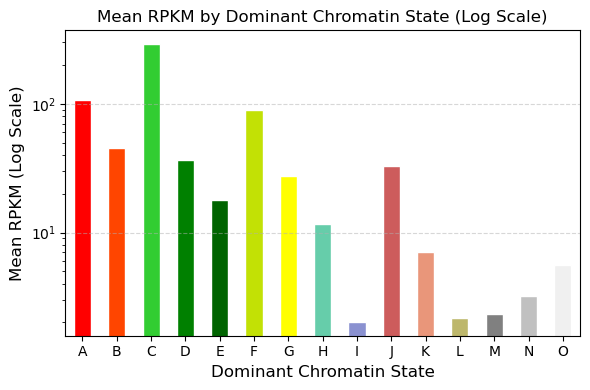

In [60]:
directory = "../database_exp/RNA/hg19/gene_expression/css_unit_and_rpkm"
concatenated_df = concatenate_css_unit_and_rpkm(directory)
dominant_state_rpkm = downstream_analysis_1_dominant_state_analysis(concatenated_df, state_col_dict_num)


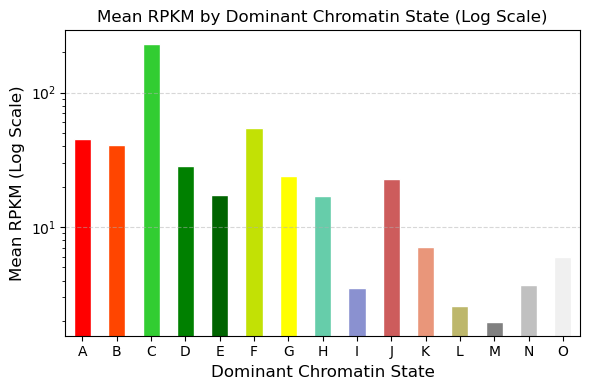

In [61]:
########### with entire "O" state for promoter regions
prom_with_ent_o_directory = "../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/with_entire_O_state_prom_css_unit_and_rpkm"
prom_with_ent_o_concatenated_df = concatenate_css_unit_and_rpkm(prom_with_ent_o_directory)
dominant_state_rpkm = downstream_analysis_1_dominant_state_analysis(prom_with_ent_o_concatenated_df, state_col_dict_num)

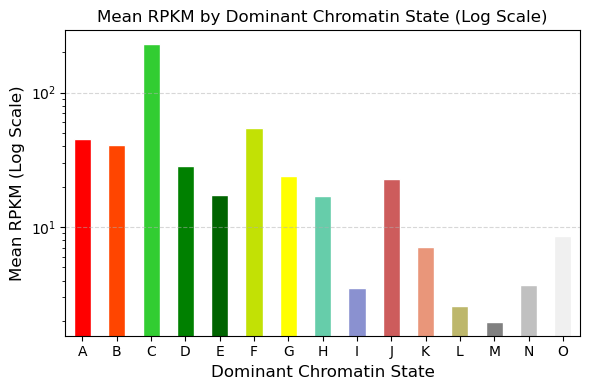

In [64]:
########### without entire "O" state for promoter regions
prom_without_ent_o_directory = "../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/without_entire_O_state_prom_css_unit_and_rpkm"
prom_without_ent_o_concatenated_df = concatenate_css_unit_and_rpkm(prom_without_ent_o_directory)
dominant_state_rpkm = downstream_analysis_1_dominant_state_analysis(prom_without_ent_o_concatenated_df, state_col_dict_num)

In [168]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def compare_and_plot_line_count_difference(dir_with, dir_without):
    """
    Compare line counts between two directories and plot the distribution of differences.
    Files are matched based on the first 4 characters of their filenames (cell IDs).
    Adds an additional plot for the proportion of the line count differences.

    Args:
        dir_with (str): Path to the directory containing files with "O" states.
        dir_without (str): Path to the directory containing files without "O" states.
    """
    # List all files in both directories
    files_with = sorted(os.listdir(dir_with))
    files_without = sorted(os.listdir(dir_without))
    
    # Extract cell IDs from both directories
    cell_ids_with = {f[:4]: f for f in files_with}
    cell_ids_without = {f[:4]: f for f in files_without}

    # Match files by cell IDs and calculate line count differences
    line_count_diff = []
    proportion_diff = []

    for cell_id, file_with in cell_ids_with.items():
        if cell_id in cell_ids_without:
            file_without = cell_ids_without[cell_id]
            path_with = os.path.join(dir_with, file_with)
            path_without = os.path.join(dir_without, file_without)
            
            # Count lines in both files (excluding the header)
            lines_with = sum(1 for line in open(path_with)) - 1
            lines_without = sum(1 for line in open(path_without)) - 1
            
            # Calculate the difference and proportion
            diff = lines_with - lines_without
            proportion = diff / lines_with if lines_with > 0 else 0
            
            line_count_diff.append(diff)
            proportion_diff.append(proportion)
        else:
            print(f"Warning: No matching file for {file_with} in {dir_without}")
    
    # Plot the distribution of line count differences and proportions
    fig, axes = plt.subplots(1, 2, figsize=(6, 4), gridspec_kw={'width_ratios': [1, 1]})

    # Plot 1: Line count differences
    axes[0].boxplot(
        line_count_diff, 
        vert=True, 
        patch_artist=True, 
        showmeans=False, 
        boxprops=dict(facecolor="white", edgecolor="teal"),
        whiskerprops=dict(color="teal"),
        capprops=dict(color="teal"),
        medianprops=dict(color="red"),
        flierprops=dict(marker='o',  markerfacecolor='teal', markeredgecolor='white',  alpha=0.5) 
    )
    axes[0].set_title("Line Count Differences", fontsize=10)
    axes[0].set_ylabel("Line Count Difference", fontsize=10)
    axes[0].set_xticks([1])
    axes[0].set_xticklabels(["Number of cases with all 'O' states"], fontsize=10)
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)

    # Plot 2: Proportion of differences
    axes[1].boxplot(
        proportion_diff, 
        vert=True, 
        patch_artist=True, 
        showmeans=False, 
        boxprops=dict(facecolor="white", edgecolor="teal"),
        whiskerprops=dict(color="teal"),
        capprops=dict(color="teal"),
        medianprops=dict(color="red"),
        flierprops=dict(marker='o',  markerfacecolor='teal', markeredgecolor='white',  alpha=0.5) 
    )
    axes[1].set_title("Proportion of Line Differences", fontsize=10)
    axes[1].set_ylabel("Proportion Difference", fontsize=10)
    axes[1].set_xticks([1])
    axes[1].set_xticklabels(["Proportion of cases with all 'O' states"], fontsize=10)
    axes[1].grid(axis="y", linestyle="--", alpha=0.7)

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    return line_count_diff, proportion_diff


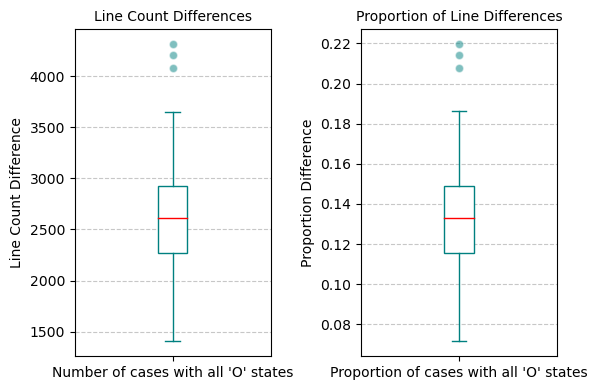

In [169]:

# Example usage
dir_with = "../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/with_entire_O_state_prom_css_unit_and_rpkm"
dir_without = "../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/without_entire_O_state_prom_css_unit_and_rpkm"

line_count_differences, proportion_differences = compare_and_plot_line_count_difference(dir_with, dir_without)


In [125]:
# Path to your input file
file_path = "../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/with_entire_O_state_prom_css_unit_and_rpkm_concatenated.csv"

# Load the CSV file excluding the header
df = pd.read_csv(file_path)

# Select rows from 10th to 20th (0-based indexing, so 9:20)
selected_rows = df.iloc[100:110]  # 10th to 20th rows

# Iterate over the selected rows and display the colored sequences with RPKM
for _, row in selected_rows.iterrows():
    sequence = row['sequence']
    rpkm = row['RPKM']
    
    # Color the sequence and add RPKM next to it
    col_str = ""
    for letter in sequence:
        for state in list(state_col_255_dict.keys()):
            if letter == state:
                r, g, b = state_col_255_dict[letter]
                col_letter = f"\033[38;2;{r};{g};{b}m{letter}\033[0m"
                col_str += col_letter
    # Print the colored sequence with the RPKM value next to it
    print(f"{col_str}  {rpkm}")


OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO  0.018
OOOOOOOONNNNNNNNNNNNMMMLLMLKKJM  0.006
OOOOOOAAAAAAAAAAEEDDDDDDDDDDDDD  83.806
EEEEEEGGGGGGAAAAAAAAAAAKKKGGGGO  26.401
GLLMMMMMMMMJJKJKKMMNNNNNNNNNNNN  2.397
OOOOOOOOGGBBBAAAAAAAAAAAAABEEEE  19.179
FFFFFFFFFCCCCCCAAAAAAAAAABGGGGG  377.137
GGGGGGGGGOOOOOOOOOOOOOOOOOOOOOO  0.002
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO  0.011
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO  0.02


In [223]:
file_without_entire_O = '../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/without_entire_O_state_prom_css_unit_and_rpkm_concatenated.csv'

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
file_with_O = '../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/with_entire_O_state_prom_css_unit_and_rpkm_concatenated.csv'
file_without_O = '../database_exp/RNA/hg19/gene_expression/promoter_region/up2kdown4k/without_entire_O_state_prom_css_unit_and_rpkm_concatenated.csv'


In [238]:
# Load the datasets
data_with_O = pd.read_csv(file_with_O)
data_without_O = pd.read_csv(file_without_O)

In [241]:
data_without_O["RPKM"]

0          0.034
1         28.307
2         10.888
3          0.997
4          0.000
           ...  
951727     0.204
951728     3.305
951729     0.764
951730     2.718
951731     2.749
Name: RPKM, Length: 951732, dtype: float64

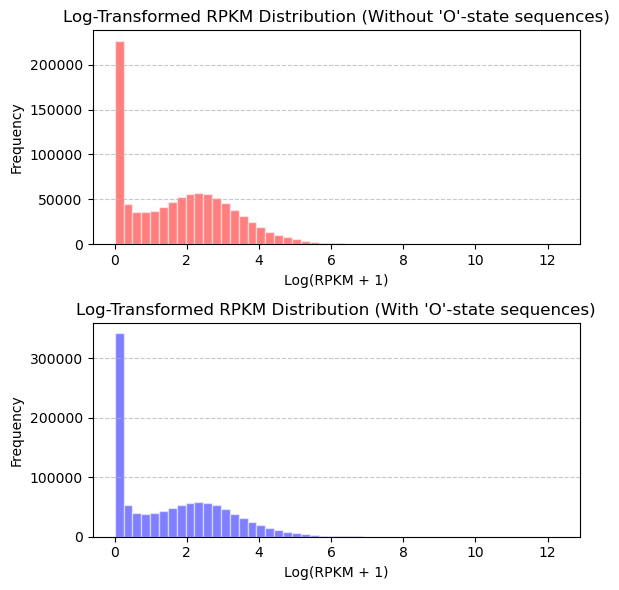

In [243]:

################ log scale rpkm ################

# Convert RPKM values to log scale (log1p to handle zero values)
log_rpkm_without_O = np.log1p(data_without_O["RPKM"])
log_rpkm_with_O = np.log1p(data_with_O["RPKM"])

# Create the figure with two subplots (upper and lower)
fig, axes = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [1, 1]})

# Plot histogram for data without "O" states
axes[0].hist(log_rpkm_without_O, bins=50, color="red", edgecolor="white", alpha=0.5)
axes[0].set_title("Log-Transformed RPKM Distribution (Without 'O'-state sequences)", fontsize=12)
axes[0].set_xlabel("Log(RPKM + 1)", fontsize=10)
axes[0].set_ylabel("Frequency", fontsize=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot histogram for data with "O" states
axes[1].hist(log_rpkm_with_O, bins=50, color="blue", edgecolor="white", alpha=0.5)
axes[1].set_title("Log-Transformed RPKM Distribution (With 'O'-state sequences)", fontsize=12)
axes[1].set_xlabel("Log(RPKM + 1)", fontsize=10)
axes[1].set_ylabel("Frequency", fontsize=10)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

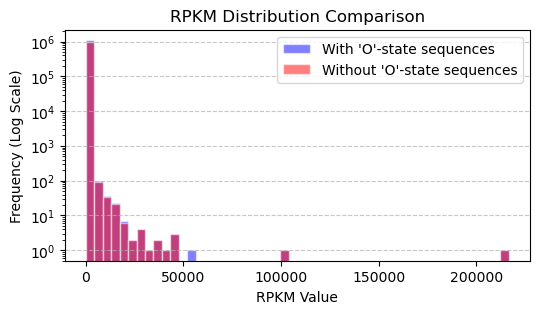

RPKM Summary: With 'O'-state sequences
count    1.099920e+06
mean     1.859758e+01
std      2.979611e+02
min      0.000000e+00
25%      8.100000e-02
50%      3.174000e+00
75%      1.329800e+01
max      2.164490e+05
Name: RPKM, dtype: float64

RPKM Summary: Without 'O'-state sequences
count    951732.000000
mean         21.031462
std         313.960893
min           0.000000
25%           0.346000
50%           4.774500
75%          15.598250
max      216449.000000
Name: RPKM, dtype: float64


In [ ]:



# Extract RPKM values
rpkm_with_O = data_with_O['RPKM']
rpkm_without_O = data_without_O['RPKM']

# Plot RPKM distributions
plt.figure(figsize=(10, 5))
plt.hist(rpkm_with_O, bins=50, alpha=0.5, label="With 'O'-state sequences", color="blue", log=True)
plt.hist(rpkm_without_O, bins=50, alpha=0.5, label="Without 'O'-state sequences", color="red", log=True)
plt.title("RPKM Distribution Comparison")
plt.xlabel("RPKM Value")
plt.ylabel("Frequency (Log Scale)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Describe the RPKM distributions numerically
summary_with_O = rpkm_with_O.describe()
summary_without_O = rpkm_without_O.describe()

# Print summaries
print("RPKM Summary: With 'O'-state sequences")
print(summary_with_O)
print("\nRPKM Summary: Without 'O'-state sequences")
print(summary_without_O)


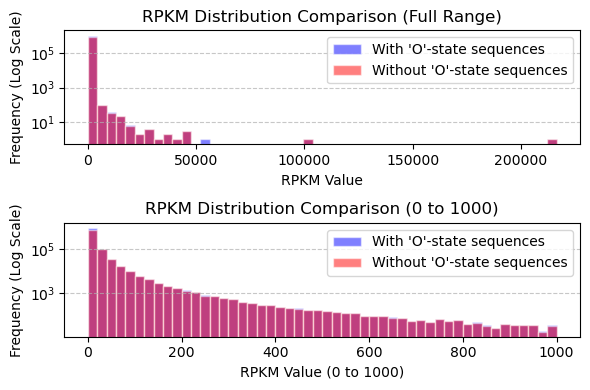

RPKM Summary: With 'O'-state sequences
count    1.099920e+06
mean     1.859758e+01
std      2.979611e+02
min      0.000000e+00
25%      8.100000e-02
50%      3.174000e+00
75%      1.329800e+01
max      2.164490e+05
Name: RPKM, dtype: float64

RPKM Summary: Without 'O'-state sequences
count    951732.000000
mean         21.031462
std         313.960893
min           0.000000
25%           0.346000
50%           4.774500
75%          15.598250
max      216449.000000
Name: RPKM, dtype: float64


In [198]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
data_with_O = pd.read_csv(file_with_O)
data_without_O = pd.read_csv(file_without_O)

# Extract RPKM values
rpkm_with_O = data_with_O['RPKM']
rpkm_without_O = data_without_O['RPKM']

# Create the figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(6, 4), gridspec_kw={'height_ratios': [1, 1]})

# Main plot: Full range histogram
axes[0].hist(rpkm_with_O, bins=50, alpha=0.5, label="With 'O'-state sequences", color="blue", edgecolor="white", log=True)
axes[0].hist(rpkm_without_O, bins=50, alpha=0.5, label="Without 'O'-state sequences", color="red", edgecolor="white",log=True)
axes[0].set_title("RPKM Distribution Comparison (Full Range)", fontsize=12)
axes[0].set_xlabel("RPKM Value", fontsize=10)
axes[0].set_ylabel("Frequency (Log Scale)", fontsize=10)
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Subplot: Focused range histogram (0 to 1000)
rpkm_range_with_O = rpkm_with_O[rpkm_with_O <= 1000]
rpkm_range_without_O = rpkm_without_O[rpkm_without_O <= 1000]

axes[1].hist(rpkm_range_with_O, bins=50, alpha=0.5, label="With 'O'-state sequences", color="blue", edgecolor="white",log=True)
axes[1].hist(rpkm_range_without_O, bins=50, alpha=0.5, label="Without 'O'-state sequences", color="red", edgecolor="white",log=True)
axes[1].set_title("RPKM Distribution Comparison (0 to 1000)", fontsize=12)
axes[1].set_xlabel("RPKM Value (0 to 1000)", fontsize=10)
axes[1].set_ylabel("Frequency (Log Scale)", fontsize=10)
# axes[1].set_xlim([0, 0.1])
# axes[1].set_ylim([0, 1000000])
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

# Describe the RPKM distributions numerically
summary_with_O = rpkm_with_O.describe()
summary_without_O = rpkm_without_O.describe()

# Print summaries
print("RPKM Summary: With 'O'-state sequences")
print(summary_with_O)
print("\nRPKM Summary: Without 'O'-state sequences")
print(summary_without_O)


In [140]:
zero_fraction_with_O = (rpkm_with_O == 0).mean()
zero_fraction_without_O = (rpkm_without_O == 0).mean()
print(f"Fraction of zero RPKM (with O): {zero_fraction_with_O:.2%}")
print(f"Fraction of zero RPKM (without O): {zero_fraction_without_O:.2%}")


Fraction of zero RPKM (with O): 12.92%
Fraction of zero RPKM (without O): 8.31%


In [141]:

# data_with_O = data_with_O[data_with_O['RPKM'] > 0]
data_without_all_O_without_rpkm_zero = data_without_O[data_without_O['RPKM'] > 0]
data_without_all_O_with_rpkm_zero = data_without_O

In [142]:
data_without_all_O_without_rpkm_zero.describe()

,RPKM
count,872684.000000
mean,22.936499
std,327.805416
min,0.001000
25%,0.942000
50%,5.946000
75%,17.233000
max,216449.000000


In [143]:
data_without_all_O_with_rpkm_zero.describe()

,RPKM
count,951732.000000
mean,21.031462
std,313.960893
min,0.000000
25%,0.346000
50%,4.774500
75%,15.598250
max,216449.000000


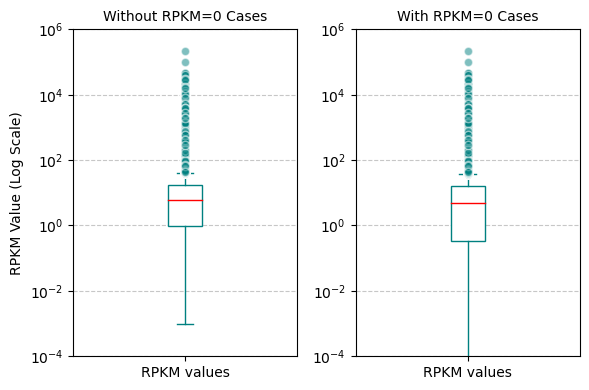

In [167]:
import matplotlib.pyplot as plt

# Extract RPKM values for the two datasets
rpkm_without_rpkm_zero = data_without_all_O_without_rpkm_zero['RPKM']
rpkm_with_rpkm_zero = data_without_all_O_with_rpkm_zero['RPKM']

# Create a whisker box plot with two subfigures
fig, axes = plt.subplots(1, 2, figsize=(6, 4), gridspec_kw={'width_ratios': [1, 1]})

# Define consistent y-axis scale and ticks
y_ticks = [10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]

# Boxplot for the dataset without RPKM=0 cases
axes[0].boxplot(
    rpkm_without_rpkm_zero,
    vert=True,
    patch_artist=True,
    showmeans=False,
    boxprops=dict(facecolor="white", edgecolor="teal"),
    whiskerprops=dict(color="teal"),
    capprops=dict(color="teal"),
    medianprops=dict(color="red"),
    flierprops=dict(marker='o',  markerfacecolor='teal', markeredgecolor='white',  alpha=0.5)  # Set outliers to teal with alpha
)
axes[0].set_title("Without RPKM=0 Cases", fontsize=10)
axes[0].set_ylabel("RPKM Value (Log Scale)", fontsize=10)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)
axes[0].set_yscale("log")
axes[0].set_ylim(10**-2, 10**4)  # Consistent y-axis limits
axes[0].set_yticks(y_ticks)  # Set consistent y-ticks
axes[0].set_xticklabels(["RPKM values"], fontsize=10)

# Boxplot for the dataset with RPKM=0 cases
axes[1].boxplot(
    rpkm_with_rpkm_zero,
    vert=True,
    patch_artist=True,
    showmeans=False,
    boxprops=dict(facecolor="white", edgecolor="teal"),
    whiskerprops=dict(color="teal"),
    capprops=dict(color="teal"),
    medianprops=dict(color="red"),
    flierprops=dict(marker='o', markerfacecolor='teal', markeredgecolor='white', alpha=0.5)  # Set outliers to teal with alpha
)
axes[1].set_title("With RPKM=0 Cases", fontsize=10)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)
axes[1].set_yscale("log")
axes[1].set_ylim(10**-2, 10**4)  # Consistent y-axis limits
axes[1].set_yticks(y_ticks)  # Set consistent y-ticks
axes[1].set_xticklabels(["RPKM values"], fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()


In [220]:
# Select rows where the sequence is entirely 'O' and RPKM is high
high_rpkm_O_state_higher_than_1 = data_with_O[(data_with_O['sequence'].str.fullmatch('O+')) & (data_with_O['RPKM'] > 1)]

rpkm_O_state_all = data_with_O[(data_with_O['sequence'].str.fullmatch('O+'))]


# Display the result
rpkm_O_state_all['RPKM'].describe()

count    148188.000000
mean          2.966054
std         160.058273
min           0.000000
25%           0.000000
50%           0.008000
75%           0.196000
max       52706.900000
Name: RPKM, dtype: float64

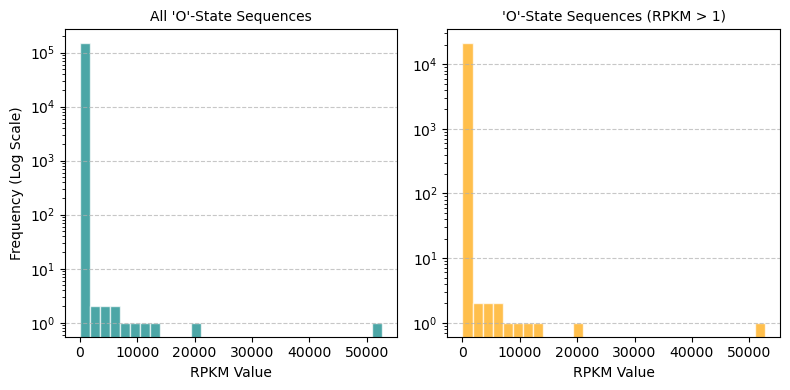

In [209]:
import matplotlib.pyplot as plt

# Extract RPKM values
rpkm_all_O = rpkm_O_state_all['RPKM']
rpkm_high_O = high_rpkm_O_state_higher_than_1['RPKM']

# Create the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1]})

# Histogram for all "O"-state sequences
axes[0].hist(rpkm_all_O, bins=30, alpha=0.7, color="teal", edgecolor="white", log=True)
axes[0].set_title("All 'O'-State Sequences", fontsize=10)
axes[0].set_xlabel("RPKM Value", fontsize=10)
axes[0].set_ylabel("Frequency (Log Scale)", fontsize=10)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Histogram for "O"-state sequences with RPKM > 1
axes[1].hist(rpkm_high_O, bins=30, alpha=0.7, color="orange", edgecolor="white", log=True)
axes[1].set_title("'O'-State Sequences (RPKM > 1)", fontsize=10)
axes[1].set_xlabel("RPKM Value", fontsize=10)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


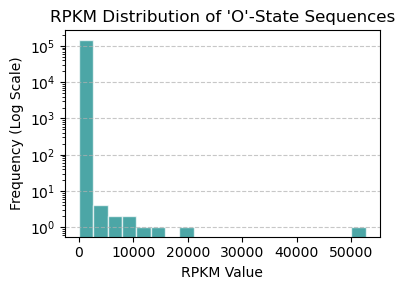

In [213]:
# Extract RPKM values for all "O"-state sequences
rpkm_all_O = rpkm_O_state_all['RPKM']

# Create the figure
plt.figure(figsize=(4, 3))

# Plot histogram
plt.hist(rpkm_all_O, bins=20, alpha=0.7, color="teal", edgecolor="white", log=True)

# Labels and Title
plt.title("RPKM Distribution of 'O'-State Sequences", fontsize=12)
plt.xlabel("RPKM Value", fontsize=10)
plt.ylabel("Frequency (Log Scale)", fontsize=10)

# Grid
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


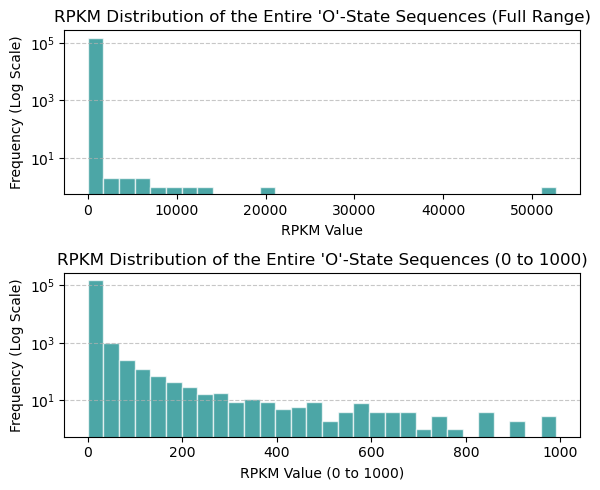

In [217]:
import matplotlib.pyplot as plt

# Extract RPKM values for all "O"-state sequences
rpkm_all_O = rpkm_O_state_all['RPKM']

# Create the figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(6, 5), gridspec_kw={'height_ratios': [1, 1]})

# Main plot: Full range histogram
axes[0].hist(rpkm_all_O, bins=30, alpha=0.7, color="teal", edgecolor="white", log=True)
axes[0].set_title("RPKM Distribution of the Entire 'O'-State Sequences (Full Range)", fontsize=12)
axes[0].set_xlabel("RPKM Value", fontsize=10)
axes[0].set_ylabel("Frequency (Log Scale)", fontsize=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Subplot: Focused range histogram (0 to 1000)
rpkm_range_O = rpkm_all_O[rpkm_all_O <= 1000]
axes[1].hist(rpkm_range_O, bins=30, alpha=0.7, color="teal", edgecolor="white", log=True)
axes[1].set_title("RPKM Distribution of the Entire 'O'-State Sequences (0 to 1000)", fontsize=12)
axes[1].set_xlabel("RPKM Value (0 to 1000)", fontsize=10)
axes[1].set_ylabel("Frequency (Log Scale)", fontsize=10)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


In [118]:
import numpy as np
# data_with_O['RPKM'] = np.log1p(data_with_O['RPKM'])
data_without_O['RPKM'] = np.log1p(data_without_O['RPKM'])

In [119]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal')
# data_with_O['RPKM'] = qt.fit_transform(data_with_O[['RPKM']])
data_without_O['RPKM'] = qt.fit_transform(data_without_O[['RPKM']])


In [120]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_with_O, test_size=0.2, stratify=pd.cut(data_with_O['RPKM'], bins=10))


In [121]:
train

,sequence,RPKM
817268,EEEEEGGAAAAABBGEEEEEEEEEEEEEEEE,0.728978
105707,DDDDDCAAAAAAAAAAAAAAAAAOOOOOOOO,2.791576
885604,DFFEEEEEEEEEEEEEEEEEEEEEEEEEEEE,1.091261
206639,EGBAAAAAAAAAAAABGBGGEEDDDDEEEEE,0.543099
160936,OOOOOOOOOOOOOOOOOAAAAAAAAAAABBB,0.280674
...,...,...
666035,EEEEEBBAAAAAABBBEEEEEEEEEEEEEEE,-0.436225
687212,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,-0.760933
334378,NNNNNNNNMMLLMMMMMMMNNNNNNNNNNNN,-2.289988
336318,DEEGBBBBBAAAAAABGGGEEEEEEBBAAAA,0.437588


In [101]:
def downstream_analysis_2_correlation_heatmap(df, rpkm_bins):
    """
    Create a heatmap showing the correlation between dominant chromatin states and binned RPKM values,
    with high RPKM bins at the top and a monotonic colormap.

    Args:
        df (pd.DataFrame): DataFrame containing 'sequence' and 'RPKM' columns.
        rpkm_bins (list): List of bin edges for RPKM values.

    Returns:
        None: Displays a heatmap.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    from collections import Counter
    import numpy as np

    # Identify the most frequent (or co-dominant) chromatin states
    def find_dominant_states(seq):
        counts = Counter(seq)
        max_freq = max(counts.values())
        return [state for state, freq in counts.items() if freq == max_freq]

    # Expand the DataFrame to account for co-dominant states
    df["dominant_states"] = df["sequence"].apply(find_dominant_states)
    expanded_rows = []
    for _, row in df.iterrows():
        for state in row["dominant_states"]:
            expanded_rows.append({"dominant_state": state, "RPKM": row["RPKM"]})
    expanded_df = pd.DataFrame(expanded_rows)

    # Bin the RPKM values
    expanded_df["RPKM_bin"] = pd.cut(expanded_df["RPKM"], bins=rpkm_bins, labels=False, include_lowest=True)

    # Create a pivot table: RPKM bin (rows) x dominant state (columns)
    heatmap_data = expanded_df.pivot_table(
        index="RPKM_bin", columns="dominant_state", values="RPKM", aggfunc="count", fill_value=0
    )

    # Reverse the row order to display high RPKM bins at the top
    heatmap_data = heatmap_data.iloc[::-1]

    # Define a monotonic colormap
    cmap = "crest"  # Use a Seaborn colormap that is smooth and elegant

    # Create a heatmap
    plt.figure(figsize=(10, 6))  # Adjust the figure size
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        annot=True,
        fmt="d",
        cbar_kws={"label": "Frequency"},
        annot_kws={"fontsize": 8},  # Reduce font size in cells
        linewidths=0.5
    )

    # Formatting the heatmap
    plt.title("Correlation Between Dominant Chromatin States and RPKM Bins", fontsize=12)
    plt.xlabel("Dominant Chromatin State", fontsize=12)
    plt.ylabel("RPKM Bin (High → Low)", fontsize=12)
    plt.yticks(
        ticks=np.arange(len(rpkm_bins)-1)[::-1]+0.5,
        labels=[f"{rpkm_bins[i]}-{rpkm_bins[i+1]}" for i in range(len(rpkm_bins)-1)][::-1],
        rotation=0
    )
    plt.xticks(rotation=0)
    plt.tight_layout()

    plt.show()


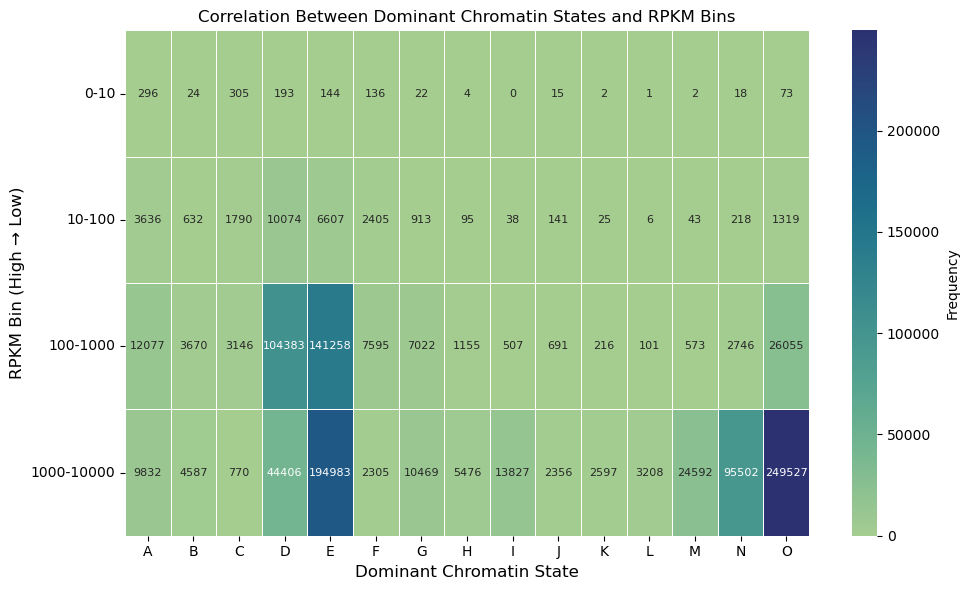

In [103]:
# Define RPKM bins (e.g., 0-10, 10-100, >100)
rpkm_bins = [0, 10, 100, 1000, 10000]

# Call the function
downstream_analysis_2_correlation_heatmap(concatenated_df, rpkm_bins)


In [52]:
def save_TSS_by_loc_IHEC(whole_gene_file, input_path="./",output_path="./",file_name="upNkdownNk", up_num=2000, down_num=4000, unit=200):
    """
    extract TSS region by location estimation. 
    input: (1) whole_gene_file: the raw gene bed file (e.g. RefSeq.WholeGene.bed)
           (2) input_path: pickled df per cell
    output: save tss_by_loc_css_unit_all at the output path
    """
    file_lst=os.listdir(input_path)
    all_files=[os.path.join(input_path,file) for file in file_lst]
    for file in all_files:
        cell_num=file.split("/")[-1][:14]
        # if cell_num=="IHECRE00000002": break  # for test 
        with open(file,"rb") as f:
            df_pickled=pickle.load(f)
        # align the gene file and the df file according to their availability(some cells does not have chr Y)
        new_gene_lst_all, trimmed_df=remove_chrM_and_trim_gene_file_accordingly(whole_gene_file,df_pickled)
        css_lst_chr = df2longcss(trimmed_df) # list of long css per chromosome
        total_chr = len(new_gene_lst_all)       
        tss_by_loc_css_all = []
        for i in range(total_chr):
            gene_start_lst = new_gene_lst_all[i]["TxStart"]
            css_lst = css_lst_chr[i]
            tss_by_loc_css_chr = []
            for j in range(len(gene_start_lst)):
                gene_start = gene_start_lst[j]
                win_start = max(0, gene_start - up_num)  # use max to prevent negative index
                win_end = min(len(css_lst), gene_start + down_num)  # use min to prevent index out of range
                tss_by_loc_css = css_lst[win_start:win_end]
                tss_by_loc_css_chr.append(tss_by_loc_css)               
            tss_by_loc_css_all.append(tss_by_loc_css_chr)
        tss_by_loc_css_unit_all=Convert2unitCSS_main_new(tss_by_loc_css_all, unit=unit)  
        tss_by_loc_css_unit_all_flat=flatLst(tss_by_loc_css_unit_all)
        output_file_name=os.path.join(output_path,cell_num+"_prom_"+file_name+".pkl")
        with open(output_file_name,"wb") as g:
            pickle.dump(tss_by_loc_css_unit_all_flat,g)

    return print("All done!") #tss_by_loc_css_unit_all_flat

In [54]:
save_TSS_by_loc_IHEC(whole_gene_file="../database/RefSeq/hg38/RefSeq.WholeGene.bed", 
                input_path="../database/df_pickled/",
                output_path="../database/prom_IHEC/prom_css_pickled/up2kdown4k",
                file_name="up2kdown4k", 
                up_num=2000, down_num=4000, unit=200)

Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene 

In [55]:
path="../database/prom_IHEC/prom_css_pickled/up2kdown4k/IHECRE00000002_prom_up2kdown4k.pkl"
with open(path,"rb") as f:
    test_css=pickle.load(f)

In [72]:
len(test_css)

21237

In [57]:
type(test_css[0])

str

In [68]:
test_css[120]

'RRRRRRRRRQQQQQQQQQQQQQQQQQQQQQ'

In [69]:
path_g="../database/css_unit_pickled/IHECRE00000001_unitcss.pkl"
with open(path_g,"rb") as g:
    test_css_g=pickle.load(g)

In [71]:
len(test_css_g)

23

In [81]:
################### This is a revised version to handle the list of list  (what we used for whole genome area) 
################### And modified to handle the faltten list (for promoter area) and an empty string element
################### When replace the original one, remain the original as commented 
def save_css_by_cell_wo_continuous_18state(path_to_css_unit_pickled, output_file, k=4, max_tokens=510):
    """
    Preprocesses CSS data and saves all processed content into a single text file, 
    removing continuous R states and splitting excess tokens into new lines.

    Args:
        path_to_css_unit_pickled (str): Path to the pickled CSS unit files.
        output_file (str): Path to save the consolidated processed file.
        k (int): Length of the k-mer. Default is 4.
        max_tokens (int): Maximum number of tokens per line. Default is 510.
    """
    # Read files from css_unit_pickled
    files = os.listdir(path_to_css_unit_pickled)
    file_path_lst = [os.path.join(path_to_css_unit_pickled, file) for file in files]
    
    all_css_kmer = []  # Collect all processed data here
    
    for file_path in file_path_lst:
        file_name = os.path.basename(file_path)
        if file_name[:4] == 'IHEC':
            file_id = file_name[:14]
        else:
            continue
        
        with open(file_path, "rb") as f:
            css = pickle.load(f)
        
        # Handle flat list input
        if isinstance(css[0], str):  # If `css` is a flat list
            css = [css]  # Wrap into a single list to process as one "chromosome"

        for css_chr_list in css:  # Iterate over sublists
            for css_chr in css_chr_list:  # Iterate over strings
                if not css_chr.strip():  # Skip empty strings
                    continue
                css_chr_kmer = seq2kmer(css_chr, k)
                target_to_remove = "R" * k  # Get rid of the word with continuous R state
                css_chr_kmer_trim = css_chr_kmer.replace(target_to_remove, "")
                # Clean up extra spaces
                css_chr_kmer_trim = ' '.join(css_chr_kmer_trim.split())
                # Split into chunks of max_tokens
                tokens = css_chr_kmer_trim.split()
                for i in range(0, len(tokens), max_tokens):
                    chunk = tokens[i:i + max_tokens]
                    all_css_kmer.append(' '.join(chunk))
    
    # Save all processed data into a single text file
    with open(output_file, "w") as g:
        for line in all_css_kmer:
            g.write(line + "\n")  # Write each chunk as a line in the file

    print("All CSS data saved into a single file: ", output_file)
    
    return


In [82]:
# to save the promoter regions only
save_css_by_cell_wo_continuous_18state(path_to_css_unit_pickled="../database/prom_IHEC/prom_css_pickled/up2kdown4k", 
                                       output_file="../database/prom_IHEC/prom_kmer_wo_cont_R/up2kdown4k/promoter_ihec_all_4mer_wo_4R.txt", 
                                       k=4, 
                                       max_tokens=510)

All CSS data saved into a single file:  ../database/prom_IHEC/prom_kmer_wo_cont_R/up2kdown4k/promoter_ihec_all_4mer_wo_4R.txt


Trimmed and chunked CSS by cell saved as .txt:  IHECRE00000001


In [27]:
file_path

'../database/pretrain/IHEC_pretrain_genome_cell01_wo4R.txt'

In [34]:
file_path_cut="../database/IHECRE00000001_test_4R_state.txt"

In [35]:
with open(file_path_cut, "r") as file:
    for line_number, line in enumerate(file, start=1):
        token_count = len(line.strip().split())  # Count the number of space-separated tokens
        print(f"Line {line_number}: {token_count} tokens")

Line 1: 510 tokens
Line 2: 510 tokens
Line 3: 510 tokens
Line 4: 510 tokens
Line 5: 510 tokens
Line 6: 510 tokens
Line 7: 510 tokens
Line 8: 510 tokens
Line 9: 510 tokens
Line 10: 510 tokens
Line 11: 510 tokens
Line 12: 510 tokens
Line 13: 510 tokens
Line 14: 510 tokens
Line 15: 510 tokens
Line 16: 510 tokens
Line 17: 510 tokens
Line 18: 510 tokens
Line 19: 510 tokens
Line 20: 510 tokens
Line 21: 510 tokens
Line 22: 510 tokens
Line 23: 510 tokens
Line 24: 510 tokens
Line 25: 510 tokens
Line 26: 510 tokens
Line 27: 510 tokens
Line 28: 510 tokens
Line 29: 510 tokens
Line 30: 510 tokens
Line 31: 510 tokens
Line 32: 510 tokens
Line 33: 510 tokens
Line 34: 510 tokens
Line 35: 510 tokens
Line 36: 510 tokens
Line 37: 510 tokens
Line 38: 510 tokens
Line 39: 510 tokens
Line 40: 510 tokens
Line 41: 510 tokens
Line 42: 510 tokens
Line 43: 510 tokens
Line 44: 510 tokens
Line 45: 510 tokens
Line 46: 510 tokens
Line 47: 510 tokens
Line 48: 510 tokens
Line 49: 510 tokens
Line 50: 510 tokens
Line 51: 

In [12]:
df_path="../database/df_pickled/IHECRE00000001.4_df_pickled.pkl"
with open(df_path,"rb") as f:
    test_df=pickle.load(f)

In [13]:
test_df

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr10,0,54200,18,54200,271,R,RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR...
1,chr10,54200,55800,17,1600,8,Q,QQQQQQQQ
2,chr10,55800,73600,18,17800,89,R,RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR...
3,chr10,73600,74200,2,600,3,B,BBB
4,chr10,74200,86000,17,11800,59,Q,QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ...
...,...,...,...,...,...,...,...,...
595033,chrX,155997800,155998200,13,400,2,M,MM
595034,chrX,155998200,156004800,12,6600,33,L,LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
595035,chrX,156004800,156005000,13,200,1,M,M
595036,chrX,156005000,156006000,12,1000,5,L,LLLLL


In [14]:
test_css=df2unitcss(test_df)

In [15]:
type(test_css)

list

In [16]:
len(test_css)

23

In [11]:
len(test_css[0])

668987

In [10]:
test_css[0][5000:5400]

'EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEFFFFFFFFFRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRIIFEEEEEEEFFFFFFFFFFFFFFFFFEEEGGGGGGGGGGGGGGGGGGGGFFFFFFBAAAAAABBBBBBBDKKKKKGGGGGGGGGGGGKKKKKKKBBAAAABBBBKKKKKKKKKKDDKFFFGGGGGFEEEEEEEEEEEEEEFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFKKFFFFEEEEEEEEEEEEEEEEEEEEEEEFFFFFFFFFEEEEEEEE'

In [ ]:
df_path="../database/df_pickled"
output_path="../database/css_unit_pickled"
for file_name in os.listdir(df_path):
    with open(file_name,"rb") as f:
        df=pickle.load(f)
        if file_name[:4] == 'IHEC':
            file_id = file_name[:14]
        else:
            pass
        if file_id[12:14]=="04":
            break
        unit_css=df2unitcss(df)
        output_file_name=os.path.join(output_path,file_id+"_unitcss.pkl") 
        with open(output_file_name,"wb") as g:
            pickle.dump(unit_css,g)


FileNotFoundError: [Errno 2] No such file or directory: 'IHECRE00000002.3_df_pickled.pkl'

In [18]:
df_path="../database/df_pickled"
for file_name in os.listdir(df_path):
    print(file_name[:14])

IHECRE00000001
IHECRE00000002
IHECRE00000004
IHECRE00000008
IHECRE00000009
IHECRE00000010
IHECRE00000011
IHECRE00000013
IHECRE00000014
IHECRE00000016
IHECRE00000017
IHECRE00000019
IHECRE00000022
IHECRE00000024
IHECRE00000026
IHECRE00000027
IHECRE00000031
IHECRE00000034
IHECRE00000035
IHECRE00000041
IHECRE00000043
IHECRE00000045
IHECRE00000048
IHECRE00000049
IHECRE00000051
IHECRE00000053
IHECRE00000054
IHECRE00000055
IHECRE00000056
IHECRE00000058
IHECRE00000059
IHECRE00000060
IHECRE00000070
IHECRE00000071
IHECRE00000073
IHECRE00000075
IHECRE00000076
IHECRE00000083
IHECRE00000084
IHECRE00000085
IHECRE00000087
IHECRE00000090
IHECRE00000094
IHECRE00000095
IHECRE00000096
IHECRE00000097
IHECRE00000099
IHECRE00000101
IHECRE00000102
IHECRE00000105
IHECRE00000108
IHECRE00000109
IHECRE00000112
IHECRE00000113
IHECRE00000114
IHECRE00000117
IHECRE00000118
IHECRE00000121
IHECRE00000123
IHECRE00000124
IHECRE00000125
IHECRE00000126
IHECRE00000128
IHECRE00000129
IHECRE00000132
IHECRE00000133
IHECRE0000

In [22]:
# #### To save css_unit from df_pickled in bulk
# df_path = "../database/df_pickled"
# output_path = "../database/css_unit_pickled"

# for file_name in os.listdir(df_path):
#     file_path = os.path.join(df_path, file_name)  # Full path to the file
#     with open(file_path, "rb") as f:
#         df = pickle.load(f)
        
#         # Extract file_id only for files starting with 'IHEC'
#         if file_name[:4] == 'IHEC':
#             file_id = file_name[:14]
#         else:
#             continue  # Skip files that do not match the condition

#         # Process the dataframe and save the output
#         unit_css = df2unitcss(df)
#         output_file_name = os.path.join(output_path, f"{file_id}_unitcss.pkl")
#         with open(output_file_name, "wb") as g:
#             pickle.dump(unit_css, g)
# ## this has been conducted, no need to execute again

In [ ]:
css_unit_path="../database/roadmap/prom/up2kdown4k/all_genes/"
output_path="../database/final_test/"
prom_css_Kmer_by_cell(path=path, output_path=output_path, k=4)

In [ ]:
##########################
##########################
##########################
##########################
########################## Corrected verion for max token numbers

def save_css_by_cell_wo_continuous_18state(path_to_css_unit_pickled, output_path, k=4, max_tokens=510):
    """
    Preprocesses and saves CSS per cell, per chromosome, removing continuous R states 
    and splitting excess tokens into new lines, saving output as .txt.

    Args:
        path_to_css_unit_pickled (str): Path to the pickled CSS unit files.
        output_path (str): Path to save the processed files.
        k (int): Length of the k-mer. Default is 4.
        max_tokens (int): Maximum number of tokens per line. Default is 510.
    """
    # Read files from css_unit_pickled
    files = os.listdir(path_to_css_unit_pickled)
    file_path_lst = [os.path.join(path_to_css_unit_pickled, file) for file in files]
    
    for file_path in file_path_lst:
        file_name = os.path.basename(file_path)
        if file_name[:4] == 'IHEC':
            file_id = file_name[:14]
        else:
            continue
        
        with open(file_path, "rb") as f:
            css = pickle.load(f)
        
        css_kmer = []
        for css_chr in css:
            css_chr_kmer = seq2kmer(css_chr, k)
            target_to_remove = "R" * k  # Get rid of the word with continuous R state
            css_chr_kmer_trim = css_chr_kmer.replace(target_to_remove, "")
            # Clean up extra spaces
            css_chr_kmer_trim = ' '.join(css_chr_kmer_trim.split())
            # Split into chunks of max_tokens
            tokens = css_chr_kmer_trim.split()
            for i in range(0, len(tokens), max_tokens):
                chunk = tokens[i:i + max_tokens]
                css_kmer.append(' '.join(chunk))
        
        # Save output as .txt file
        output_file_name = os.path.join(output_path, file_id + "_test_" + str(k) + "R_state.txt")
        with open(output_file_name, "w") as g:
            for line in css_kmer:
                g.write(line + "\n")  # Write each chunk as a line in the file

        print("Trimmed and chunked CSS by cell saved as .txt: ", file_id)
    
    return



In [31]:
css_unit_path="../database/css_unit_pickled_test/"
wo_R_output_path="../database"
save_css_by_cell_wo_continuous_18state(css_unit_path, wo_R_output_path, k=4, max_tokens=510)

Trimmed and chunked CSS by cell saved as .txt:  IHECRE00000001


In [41]:
###################### if successful, do this to prepare pretrain IHEC all

def save_and_concatenate_css(path_to_css_unit_pickled, concatenated_output_file, k=4, max_tokens=510):
    """
    Preprocesses CSS per cell, per chromosome, removing continuous R states,
    splitting excess tokens into new lines, and saving all processed CSS into a single file.

    Args:
        path_to_css_unit_pickled (str): Path to the pickled CSS unit files.
        concatenated_output_file (str): Path to save the concatenated .txt file.
        k (int): Length of the k-mer. Default is 4.
        max_tokens (int): Maximum number of tokens per line. Default is 510.
    """
    # Read files from css_unit_pickled
    files = os.listdir(path_to_css_unit_pickled)
    file_path_lst = [os.path.join(path_to_css_unit_pickled, file) for file in files]

    all_kmers = []  # List to store all processed css_kmers for concatenation

    for file_path in file_path_lst:
        file_name = os.path.basename(file_path)
        if file_name[:4] == 'IHEC':
            file_id = file_name[:14]
        else:
            continue
        
        with open(file_path, "rb") as f:
            css = pickle.load(f)
        
        for css_chr in css:
            css_chr_kmer = seq2kmer(css_chr, k)
            target_to_remove = "R" * k  # Get rid of the word with continuous R state
            css_chr_kmer_trim = css_chr_kmer.replace(target_to_remove, "")
            # Clean up extra spaces
            css_chr_kmer_trim = ' '.join(css_chr_kmer_trim.split())
            # Split into chunks of max_tokens
            tokens = css_chr_kmer_trim.split()
            for i in range(0, len(tokens), max_tokens):
                chunk = tokens[i:i + max_tokens]
                all_kmers.append(' '.join(chunk))  # Add each chunk directly to all_kmers

    # Save concatenated output to a single .txt file
    with open(concatenated_output_file, "w") as concat_file:
        for line in all_kmers:
            concat_file.write(line + "\n")

    print(f"All processed CSS concatenated and saved to {concatenated_output_file}")



In [42]:
save_and_concatenate_css(
    path_to_css_unit_pickled="../database/css_unit_pickled",
    concatenated_output_file="../database/pretrain/IHEC_all_genome_cut_4mer_wo_R_all_concatenated_css.txt",
    k=4,
    max_tokens=510
)

All processed CSS concatenated and saved to ../database/pretrain/IHEC_all_genome_cut_4mer_wo_R_all_concatenated_css.txt


In [25]:
# # [IHEC] Pretrain data preprocessing and storing (for 18-state version)

# # Preprocessing for removing continuous R state for pretrain dataset
# # 1-1. Save the CSS per cell, per chromosome
# def save_css_by_cell_wo_continuous_18state(path_to_css_unit_pickled, output_path,k=4):
#     # read files from css_unit_pickled
#     files=os.listdir(path_to_css_unit_pickled)
#     file_path_lst=[os.path.join(path_to_css_unit_pickled,file) for file in files]
#     for file_path in file_path_lst:
#         file_name=os.path.basename(file_path)
#         if file_name[:4] == 'IHEC':
#             file_id = file_name[:14]
#         else:
#             pass
#         # ##########################
#         # if str(file_id)=="E003":
#         #     break  # for test
#         # ##########################
#         with open(file_path,"rb") as f:
#             css=pickle.load(f)
#         css_kmer=[]
#         for css_chr in css:
#             css_chr_kmer=seq2kmer(css_chr,k)
#             target_to_remove="R"*k   # get rid of the word with continuous 15th state "o"
#             css_chr_kmer_trim = css_chr_kmer.replace(target_to_remove, "")
#             # clean up extra spaces
#             css_chr_kmer_trim = ' '.join(css_chr_kmer_trim.split())
#             css_kmer.append(css_chr_kmer_trim)
#         output_file_name=os.path.join(output_path,file_id+"_unitcss_wo_all"+str(k)+"R_state.pkl")    
#         with open(output_file_name, "wb") as g:
#             pickle.dump(css_kmer, g)  # note that it is chromosome-wise list (each element corresponds to each chromosome)

#         print("trimmed css by cell saved: ",file_id)
#     return 

In [2]:
# css_unit_path="../database/css_unit_pickled"
# wo_R_output_path="../database/wo_R_css_unit/4mer"

# save_css_by_cell_wo_continuous_18state(css_unit_path,wo_R_output_path, k=4)

In [27]:
with open("../database/wo_R_css_unit/4mer/IHECRE00000001_unitcss_wo_all4R_state.pkl", "rb") as fff:
    test_wor=pickle.load(fff)

In [28]:
type(test_wor)

list

In [30]:
len(test_wor[0])

1946549

In [31]:
test_wor[0][:400]

'RRRQ RRQQ RQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQR QQRR QRRR RRRB RRBB RBBB BBBQ BBQQ BQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQQ QQQR QQRR QRRR RRRM RRMM RMMM MMMM '

In [36]:
# Preprocessing for removing continuous O state for pretrain dataset
# 2-2. Concatenate all the cells and create one .txt file (IHEC file version)
# (Note. new line joining chromosome-wise and cell-wise)
# def kmerCSS_to_pretrain_data_ihec(path_to_kmer_css_unit_pickled,output_path):
#     files=os.listdir(path_to_kmer_css_unit_pickled)
#     file_path_lst=[os.path.join(path_to_kmer_css_unit_pickled,file) for file in files]

#     css_all=[]
#     for file_path in file_path_lst:
#         file_name=os.path.basename(file_path)
#         if file_name[:4] == 'IHEC':
#             file_id = file_name[:14]
#         else:
#             pass
#         # ##########################
#         # if str(file_id)=="E003":
#         #     break  # for test
#         # # ##########################
#         with open(file_path,"rb") as f:
#             css=pickle.load(f)

#         css_per_cell='\n'.join(css)   # join the chromosome by new line

#         css_all.append(css_per_cell)   

#     css_all_cell='\n'.join(css_all)  # join the cell by new line

#     output_name=os.path.join(output_path,"IHEC_pretrain_genome_all_wo4R.txt") 
#     with open(output_name, "w") as g:
#         g.write(css_all_cell)


def kmerCSS_to_pretrain_data_ihec(path_to_kmer_css_unit_pickled, output_path):
    files = os.listdir(path_to_kmer_css_unit_pickled)
    file_path_lst = [os.path.join(path_to_kmer_css_unit_pickled, file) for file in files]

    output_name = os.path.join(output_path, "IHEC_pretrain_genome_all_wo4R.txt")
    with open(output_name, "w") as g:
        for file_path in file_path_lst:
            file_name = os.path.basename(file_path)
            
            if file_name[:4] == 'IHEC':
                file_id = file_name[:14]
            else:
                continue
            
            # Load the CSS data for each cell
            with open(file_path, "rb") as f:
                css = pickle.load(f)
            
            # Write the chromosome data for this cell, joined by new lines, directly to the output file
            css_per_cell = '\n'.join(css)  # Join chromosomes by new lines
            g.write(css_per_cell + '\n')   # Write to the output file and add a newline between cells




In [37]:
path_to_kmer_css_unit_pickled="../database/wo_R_css_unit/4mer"
output_path="../database/pretrain"
kmerCSS_to_pretrain_data_ihec(path_to_kmer_css_unit_pickled,output_path)

In [4]:
file_path="../database/wo_R_css_unit/4mer/IHECRE00000001_unitcss_wo_all4R_state.pkl"
output_path="../database/pretrain"
output_name = os.path.join(output_path, "IHEC_pretrain_genome_cell01_wo4R.txt")

with open(file_path, "rb") as f:
    css = pickle.load(f)
    with open(output_name, "w") as g:
        css_per_cell = '\n'.join(css) # Join chromosomes by new lines
        g.write(css_per_cell + '\n')

In [5]:
output_name

'../database/pretrain/IHEC_pretrain_genome_cell01_wo4R.txt'

In [12]:
file_path = "../database/pretrain/IHEC_pretrain_genome_cell01_wo4R.txt"
output_path = "../database/pretrain/invalid_lines.txt"

try:
    with open(file_path, "r") as f:
        lines = f.readlines()

    invalid_lines = []
    valid_chars = set("ABCDEFGHIJKLMNOPQR")

    for i, line in enumerate(lines):
        line = line.strip()
        # Split by spaces and validate each 4-mer
        tokens = line.split()
        if not all(len(token) == 4 and set(token).issubset(valid_chars) for token in tokens):
            invalid_lines.append((i + 1, line))

    # Save invalid lines to a file
    with open(output_path, "w") as out_file:
        for line_number, content in invalid_lines:
            out_file.write(f"Line {line_number}: {content}\n")

    print(f"Found {len(invalid_lines)} invalid lines. Saved to {output_path}")

except FileNotFoundError:
    print(f"File not found: {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")


Found 0 invalid lines. Saved to ../database/pretrain/invalid_lines.txt


In [19]:
from transformers import DNATokenizer

# Initialize the tokenizer
tokenizer = DNATokenizer.from_pretrained("dev/training/src/transformers/dnabert-config/bert-config-4")

# Test a space-separated input
test_line = "QQQQ QQQQ QQQQ QQQQ"

try:
    batch_outputs = tokenizer.batch_encode_plus(
        [test_line],
        add_special_tokens=True,
        max_length=512,
        truncation=True
    )
    print("Encoded outputs:", batch_outputs)
except Exception as e:
    print(f"Tokenizer failed: {e}")


ImportError: cannot import name 'DNATokenizer' from 'transformers' (/home/lee/miniconda3/envs/chrombert/lib/python3.8/site-packages/transformers/__init__.py)

In [ ]:
# place this at the end

# if __name__ == "__main__":
#     if len(sys.argv) > 1:
#         func_name = sys.argv[1]
#         globals()[func_name]()  

In [2]:
# test_file.bed is the 4th column (state is converted to only have number)
# using the command: awk 'BEGIN{FS=OFS="\t"} {split($4, a, "_"); $4 = a[1]; print}' filename.bed > modified_filename.bed

bed_path="../database/bed/IHEC_unzipped/test_file.bed"

In [3]:
def bed2df_expanded(filename, state_num=15):
    """Create an expanded dataframe from the .bed file.
    Dataframe contains following columns:
    chromosome |  start |  end  | state | length | unit | state_seq | state_seq_full"""
    if not os.path.exists(filename):
        raise FileNotFoundError("Please provide a valid file path.")

    df_raw=pd.read_csv(filename, sep='\t', lineterminator='\n', header=None, low_memory=False)
    df=df_raw.rename(columns={0:"chromosome",1:"start",2:"end",3:"state"})
    df=df[:-1]
    df["start"]=pd.to_numeric(df["start"])
    df["end"]=pd.to_numeric(df["end"])
    df["state"]=pd.to_numeric(df["state"])
    df["length"]=df["end"]-df["start"]
    df["unit"]=(df["length"]/200).astype(int)  # chromatin state is annotated every 200 bp (18th May 2022)
    ##################### modified to accommodate 18 states
    if state_num==18:
        df["state_seq"]=df["state"].map(state_dict_18)
        df["state_seq_full"]=df["unit"]*df["state_seq"]
    #######################################################
    else:
        df["state_seq"]=df["state"].map(state_dict)
        df["state_seq_full"]=df["unit"]*df["state_seq"]
    
    return df 

In [4]:
df=bed2df_expanded(bed_path, 18)

In [5]:
df

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr10,0,73800,18,73800,369,R,RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR...
1,chr10,73800,74200,2,400,2,B,BB
2,chr10,74200,76200,6,2000,10,F,FFFFFFFFFF
3,chr10,76200,76600,2,400,2,B,BB
4,chr10,76600,87200,18,10600,53,R,RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR...
...,...,...,...,...,...,...,...,...
331556,chrX,156000200,156000400,11,200,1,K,K
331557,chrX,156000400,156000600,9,200,1,I,I
331558,chrX,156000600,156001200,10,600,3,J,JJJ
331559,chrX,156001200,156002000,9,800,4,I,IIII


In [6]:
df["chromosome"].unique()

array(['chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
       'chr17', 'chr18', 'chr19', 'chr1', 'chr20', 'chr21', 'chr22',
       'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chrX'], dtype=object)

In [8]:
np.size(df["chromosome"].unique())

23

In [20]:
test_css=df2unitcss(df)

In [22]:
len(test_css[0])

668987

In [26]:
test_css[0][5000:5500]

'EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEEEEEEEEEEEEEEEEEEEEEEEEEEEEFFJJJJJJJJJFFFFFFFFFFFFFFFAAAAAAAAAAJJJGGGGGFFFFEEEEEEEEEEFGHCCAAAAAAAAAAAAAIIIIFFFFFFFKKKKKIIIIIIIIIIIIIIIIJJJJFFFFFFFFJJJJJJJJJIIJJJJJJJJJIIIIIJJFFFFFEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEGGGGGGGGGGGGGGGEEEEEEEEEEEEEEFFFFEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE'

In [9]:
unit_css_test=df2unitcss(df)

In [13]:
len(unit_css_test[0])

668987

In [12]:
type(unit_css_test)

list

In [17]:
with open("../database/cell_pickle/df_cell001.pkl", "rb") as g:
    pick_g=pickle.load(g)

In [18]:
type(pick_g)

pandas.core.frame.DataFrame

In [19]:
pick_g

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10600,9,800,8,I,IIIIIIII
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
...,...,...,...,...,...,...,...,...
510145,chrY,59003800,59005800,15,2000,20,O,OOOOOOOOOOOOOOOOOOOO
510146,chrY,59005800,59006000,9,200,2,I,II
510147,chrY,59006000,59011800,15,5800,58,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
510148,chrY,59011800,59026000,9,14200,142,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [20]:
with open("../database/roadmap/prom/up2kdown4k/all_genes/E001_prom_up2kdown4k.pkl", "rb") as f:
    pick_f=pickle.load(f)

In [22]:
len(pick_f)

24

In [2]:
with open("../database/IHECRE00002309.1_df_pickled.pkl", "rb") as ff:
    pick_f=pickle.load(ff)

In [3]:
pick_f

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr10,0,73800,18,73800,369,R,RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR...
1,chr10,73800,74200,2,400,2,B,BB
2,chr10,74200,74400,11,200,1,K,K
3,chr10,74400,75800,17,1400,7,Q,QQQQQQQ
4,chr10,75800,76000,15,200,1,O,O
...,...,...,...,...,...,...,...,...
379399,chrX,155963000,155963800,16,800,4,P,PPPP
379400,chrX,155963800,155964400,12,600,3,L,LLL
379401,chrX,155964400,155968800,13,4400,22,M,MMMMMMMMMMMMMMMMMMMMMM
379402,chrX,155968800,155969800,12,1000,5,L,LLLLL


In [27]:
type(ff)

_io.BufferedReader